# Análise de Redes Sociais: encontrando a clique máxima em um grafo
#### Projeto SuperComputação 2023.2

Sumário

- Geração do grafo + Cálculo do clique máxima em Python

- 1° Implementação: Abordagem Exaustiva

- Sugestão de Heurística na Busca Exaustiva (Pseudo-Código)
    
- 2° Implementação: Threads OpenMP

- 3° Implementação: Paralelização e Distribuição do Processamento com MPI

- Comparação dos Resultados

### Geração do grafo + Cálculo do clique máxima em Python

In [ ]:
import networkx as nx
import random


# Parâmetros
num_vertices = 36 # Número de vértices no grafo
probabilidade_conexao = 0.7  # Probabilidade de haver uma aresta entre dois vértices (ajuste conforme necessário)

# Crie um grafo aleatório densamente conectado
grafo = nx.fast_gnp_random_graph(num_vertices, probabilidade_conexao)

# Nome do arquivo de saída
nome_arquivo = "grafo_gerado.txt"

# Abra o arquivo para escrita
with open(nome_arquivo, 'w') as arquivo:
    # Escreva a quantidade de vértices e número de arestas na primeira linha
    arquivo.write(f"{num_vertices} {grafo.number_of_edges()}\n")

    # Escreva as arestas no formato de lista de adjacência
    for aresta in grafo.edges():
        arquivo.write(f"{aresta[0]+1} {aresta[1]+1}\n")  # +1 para ajustar os índices (começando em 1)

print(f"Grafo densamente conectado gerado e salvo em '{nome_arquivo}'.")


# Nome do arquivo de entrada
nome_arquivo = "grafo_gerado.txt"

# Abrir o arquivo e pular a primeira linha
with open(nome_arquivo, 'r') as arquivo:
    next(arquivo)  # Pula a primeira linha

    # Lê o grafo a partir das linhas restantes
    G = nx.parse_adjlist(arquivo)

# Encontrar todas as cliques maximais
cliques_maximais = list(nx.find_cliques(G))

# Encontrar a clique máxima (a maior)
clique_maxima = max(cliques_maximais, key=len)
clique_maxima = sorted([int(number) for number in clique_maxima])

print(f"Número de vértices: {num_vertices}")
print(f"Cliques maximais encontradas de tamanho {len(clique_maxima)}: ")
for clique in cliques_maximais:
    if len(clique) == len(clique_maxima):
        clique = sorted([int(number) for number in clique])
        print(clique)

# print("Clique máxima encontrada:", clique_maxima)
# print("Tamanho da clique máxima encontrada:", len(clique_maxima))

### 1° Implementação: Abordagem Exaustiva

In [ ]:
%%bash
g++ -Wall -O3 -fopenmp -g exaustiva.cpp -o exaustiva
./exaustiva   

In [ ]:
%%bash
g++ -Wall -O3 -fopenmp -g openmp.cpp -o openmp
./openmp

In [ ]:
%%writefile exaustiva.cpp

#include <iostream>
#include <vector>
#include <fstream>
#include <algorithm>
#include <random>
#include <bits/stdc++.h>
#include <omp.h>
using namespace std;


// Função para ler o grafo a partir do arquivo de entrada
tuple<vector<vector<int>>, int> LerGrafo(const std::string& nomeArquivo) {
    ifstream arquivo(nomeArquivo);
    int numVertices;
    int numArestas;
    arquivo >> numVertices >> numArestas;

    vector<vector<int>> grafo(numVertices, vector<int>(numVertices, 0));

    for (int i = 0; i < numArestas; ++i) {
        int u, v;
        arquivo >> u >> v;
        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;  // O grafo é não direcionado
    }

    arquivo.close();

    return make_tuple(grafo, numVertices);
}


// Função para ver se um vértice pertence ao clique
tuple<vector<int>, vector<int>> CliqueCheck(vector<vector<int>> grafo, vector<int> candidatos, vector<int> clique, int v) {

    // Encontrar e Apagar o vértice dos candidatos
    auto it = find(candidatos.begin(), candidatos.end(), v);
    auto index = distance(candidatos.begin(), it);
    candidatos.erase(candidatos.begin() + index);

    // Ver se o vértice faz conexão com todos do clique
    bool podeAdicionar = true;
    for (auto& u : clique) {
        if (grafo[u][v] == 0) {
            podeAdicionar = false;
            break;
        }
    }

    // Se fizer conexão, é adicionado ao clique e é formado os novos candidatos
    // Se não fizer conexão, não é adicionado ao clique e os novos candidatos é vazio
    vector<int> novosCandidatos;
    if (podeAdicionar == true) {
        clique.push_back(v);

        for (auto& u : candidatos) {
            bool adjacenteATodos = true;

            for (auto& c : clique) {
                if (grafo[u][c] == 0) {
                    adjacenteATodos = false;
                    break;
                }
            }

            if (adjacenteATodos == true) {
                novosCandidatos.push_back(u);
            }
        }
    }

    return make_tuple(clique, novosCandidatos);
 }


// Função para verificar todas as possibilidades de cliques e encontrar a maior
vector<int> EncontrarCliqueMaxima(vector<vector<int>> grafo, vector<int> candidatos, vector<int> clique) {
    vector<int> cliqueMaxima;

    for (auto& c : candidatos) {
        vector<int> novosCandidatos;
        vector<int> novoClique;
        tie(novoClique, novosCandidatos) = CliqueCheck(grafo, candidatos, clique, c);

        if (!novosCandidatos.empty()) {
            novoClique = EncontrarCliqueMaxima(grafo, novosCandidatos, novoClique);
        }

        if (novoClique.size() >= cliqueMaxima.size()) {
            cliqueMaxima = novoClique;
        }
    }

    return cliqueMaxima;
}


int main() {
    int numVertices;
    vector<vector<int>> grafo;
    tie(grafo, numVertices) = LerGrafo("grafo_gerado.txt");
    cout << "Número de vértices: " << numVertices << endl;

    vector<int> candidatos;
    for (int i = 0; i <= numVertices - 1; i++) {
        candidatos.push_back(i);
    }

    vector<int> cliqueMaxima;

    double tdata = omp_get_wtime();

    cliqueMaxima = EncontrarCliqueMaxima(grafo, candidatos, cliqueMaxima);

    tdata = omp_get_wtime() - tdata;

    // PRINTS
    sort(cliqueMaxima.begin(), cliqueMaxima.end());
    cout << "Clique máxima encontrada de tamanho " << cliqueMaxima.size() << ": [";
    for (auto& v : cliqueMaxima) {
        if (&v == &cliqueMaxima.back()) {cout << v+1; } // Se for o último vértice
        else {cout << v+1 << ", "; }
    }
    cout << "]" << endl;
    cout << "Duração: " << tdata << " s";

    return 0;
}

#### Sugestão de Heurística na Busca Exaustiva (Pseudo-Código)

Introduzir uma memória para evitar o recálculo do valor de _cliqueMaxima_ quando as entradas clique (clique atual) e candidatos (vértices candidatos a entrarem no clique) já tiverem previamente calculado a sua clique máxima.

```
...
MEMORIA = {(CLIQUE, CANDIDATOS): cliqueMaxima}

// Função para verificar todas as possibilidades de cliques e encontrar a maior
vector<int> EncontrarCliqueMaxima(vector<vector<int>> grafo, vector<int> candidatos, vector<int> clique) {
    vector<int> cliqueMaxima;

    for (auto& c : candidatos) {
        vector<int> novosCandidatos;
        vector<int> novoClique1;
        tie(novoClique1, novosCandidatos) = CliqueCheck(grafo, candidatos, clique, c);

        SE novoClique1 E novosCandidatos JA EXISTIR NA MEMORIA:
            novoClique RECEBE O VALOR DA MEMORIA COM CHAVE (novoClique1, novosCandidatos)
        CASO CONTRARIO:
            if (!novosCandidatos.empty()) {
                novoClique = EncontrarCliqueMaxima(grafo, novosCandidatos, novoClique1);
                ADICIONA NA MEMORIA A CHAVE (novoClique1, novosCandidatos) COM VALOR novoClique
            }
          
        if (novoClique.size() >= cliqueMaxima.size()) {
            cliqueMaxima = novoClique;
        }
    }

    return cliqueMaxima;
}
...
```

### 2° Implementação: Implementação com Threads OpenMP

Na função _EncontrarCliqueMaxima()_, a etapa de geração de cliques no loop _for_ será paralelizada, permitindo que vários cliques sejam formados simultaneamente. Para evitar conflitos durante a atualização da variável _cliqueMaxima_, foi também incorporada uma região crítica.

In [ ]:
%%writefile openmp.cpp

#include <iostream>
#include <vector>
#include <fstream>
#include <algorithm>
#include <random>
#include <bits/stdc++.h>
#include <omp.h>
using namespace std;


// Função para ler o grafo a partir do arquivo de entrada
tuple<vector<vector<int>>, int> LerGrafo(const std::string& nomeArquivo) {
    ifstream arquivo(nomeArquivo);
    int numVertices;
    int numArestas;
    arquivo >> numVertices >> numArestas;

    vector<vector<int>> grafo(numVertices, vector<int>(numVertices, 0));

    for (int i = 0; i < numArestas; ++i) {
        int u, v;
        arquivo >> u >> v;
        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;  // O grafo é não direcionado
    }

    arquivo.close();

    return make_tuple(grafo, numVertices);
}


// Função para ver se um vértice pertence ao clique
tuple<vector<int>, vector<int>> CliqueCheck(vector<vector<int>> grafo, vector<int> candidatos, vector<int> clique, int v) {

    // Encontrar e Apagar o vértice dos candidatos
    auto it = find(candidatos.begin(), candidatos.end(), v);
    auto index = distance(candidatos.begin(), it);
    candidatos.erase(candidatos.begin() + index);

    // Ver se o vértice faz conexão com todos do clique
    bool podeAdicionar = true;
    for (auto& u : clique) {
        if (grafo[u][v] == 0) {
            podeAdicionar = false;
            break;
        }
    }

    // Se fizer conexão, é adicionado ao clique e é formado os novos candidatos
    // Se não fizer conexão, não é adicionado ao clique e os novos candidatos é vazio
    vector<int> novosCandidatos;
    if (podeAdicionar == true) {
        clique.push_back(v);

        for (auto& u : candidatos) {
            bool adjacenteATodos = true;

            for (auto& c : clique) {
                if (grafo[u][c] == 0) {
                    adjacenteATodos = false;
                    break;
                }
            }

            if (adjacenteATodos == true) {
                novosCandidatos.push_back(u);
            }
        }
    }

    return make_tuple(clique, novosCandidatos);
 }


// Função para verificar todas as possibilidades de cliques e encontrar a maior
vector<int> EncontrarCliqueMaxima(vector<vector<int>> grafo, vector<int> candidatos, vector<int> clique) {
    vector<int> cliqueMaxima;

    #pragma omp parallel for
    for (auto& c : candidatos) {
        vector<int> novosCandidatos;
        vector<int> novoClique;
        tie(novoClique, novosCandidatos) = CliqueCheck(grafo, candidatos, clique, c);

        if (!novosCandidatos.empty()) {
            novoClique = EncontrarCliqueMaxima(grafo, novosCandidatos, novoClique);
        }

        #pragma omp critical
        if (novoClique.size() >= cliqueMaxima.size()) {
            cliqueMaxima = novoClique;
        }
    }

    return cliqueMaxima;
}


int main() {
    int numVertices;
    vector<vector<int>> grafo;
    tie(grafo, numVertices) = LerGrafo("grafo_gerado.txt");
    cout << "Número de vértices: " << numVertices << endl;

    vector<int> candidatos;
    for (int i = 0; i <= numVertices - 1; i++) {
        candidatos.push_back(i);
    }

    vector<int> cliqueMaxima;

    double tdata = omp_get_wtime();

    cliqueMaxima = EncontrarCliqueMaxima(grafo, candidatos, cliqueMaxima);

    tdata = omp_get_wtime() - tdata;

    // PRINTS
    sort(cliqueMaxima.begin(), cliqueMaxima.end());
    cout << "Clique máxima encontrada de tamanho " << cliqueMaxima.size() << ": [";
    for (auto& v : cliqueMaxima) {
        if (&v == &cliqueMaxima.back()) {cout << v+1; } // Se for o último vértice
        else {cout << v+1 << ", "; }
    }
    cout << "]" << endl;
    cout << "Duração: " << tdata << " s";

    return 0;
}

### 3° Implementação: Paralelização e Distribuição do Processamento com MPI

In [ ]:
#include <iostream>
#include <vector>
#include <fstream>
#include <algorithm>
#include <random>
#include <bits/stdc++.h>
#include <mpi.h>
using namespace std;


tuple<vector<vector<int>>, int> LerGrafo(const std::string& nomeArquivo) {
    ifstream arquivo(nomeArquivo);
    int numVertices;
    int numArestas;
    arquivo >> numVertices >> numArestas;

    vector<vector<int>> grafo(numVertices, vector<int>(numVertices, 0));

    for (int i = 0; i < numArestas; ++i) {
        int u, v;
        arquivo >> u >> v;
        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;  
    }

    arquivo.close();

    return make_tuple(grafo, numVertices);
}


tuple<vector<int>, vector<int>> CliqueCheck(vector<vector<int>> grafo, vector<int> candidatos, vector<int> clique, int v) {

    auto it = find(candidatos.begin(), candidatos.end(), v);
    auto index = distance(candidatos.begin(), it);
    candidatos.erase(candidatos.begin() + index);

    bool podeAdicionar = true;
    for (auto& u : clique) {
        if (grafo[u][v] == 0) {
            podeAdicionar = false;
            break;
        }
    }

    vector<int> novosCandidatos;
    if (podeAdicionar == true) {
        clique.push_back(v);

        for (auto& u : candidatos) {
            bool adjacenteATodos = true;

            for (auto& c : clique) {
                if (grafo[u][c] == 0) {
                    adjacenteATodos = false;
                    break;
                }
            }

            if (adjacenteATodos == true) {
                novosCandidatos.push_back(u);
            }
        }
    }

    return make_tuple(clique, novosCandidatos);
 }


vector<int> EncontrarCliqueMaxima(vector<vector<int>> grafo, vector<int> candidatos, vector<int> clique) {
    vector<int> cliqueMaxima;

    for (auto& c : candidatos) {
        vector<int> novosCandidatos;
        vector<int> novoClique;
        tie(novoClique, novosCandidatos) = CliqueCheck(grafo, candidatos, clique, c);

        if (!novosCandidatos.empty()) {
            novoClique = EncontrarCliqueMaxima(grafo, novosCandidatos, novoClique);
        }

        if (novoClique.size() >= cliqueMaxima.size()) {
            cliqueMaxima = novoClique;
        }
    }

    return cliqueMaxima;
}


int main(int argc, char** argv) {

    int numVertices;
    vector<vector<int>> grafo;
    tie(grafo, numVertices) = LerGrafo("grafo_gerado.txt");
    cout << "Número de vértices: " << numVertices << endl;

    vector<int> candidatos;
    for (int i = 0; i <= numVertices - 1; i++) {
        candidatos.push_back(i);
    }

    int i;
    MPI_Status status;
    int meu_inicio = 0, meu_fim = 0;
    vector<int> cliqueMaxima;
    vector<int> CliqueMaximaParcial;
    int cand_por_proc = 0;

    MPI_Init(&argc, &argv);
    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    if (rank == 0) {
        cand_por_proc = candidatos.size() / size;
        for (i = 1; i < size; i++) {
            MPI_Send(&cand_por_proc, 1, MPI_INT, i, 0, MPI_COMM_WORLD);
        }
    } else {
        MPI_Recv(&cand_por_proc, 1, MPI_INT, 0, 0, MPI_COMM_WORLD, &status);
    }

    meu_inicio = rank * cand_por_proc;
    meu_fim = meu_inicio + cand_por_proc;
    for (i = meu_inicio; i < meu_fim; i++) {
        vector<int> novosCandidatos;
        vector<int> novoClique;
        tie(novoClique, novosCandidatos) = CliqueCheck(grafo, candidatos, novoClique, i);

        if (!novosCandidatos.empty()) {
            novoClique = EncontrarCliqueMaxima(grafo, novosCandidatos, novoClique);
        }

        if (novoClique.size() >= cliqueMaxima.size()) {
            cliqueMaxima = novoClique;
        }
    }

    if (rank != 0) {
        MPI_Send(&cliqueMaxima[0], cliqueMaxima.size(), MPI_INT, 0, 0, MPI_COMM_WORLD);
    } else {
        for(i = 1; i < size; i++) {
            MPI_Recv(&CliqueMaximaParcial[0], CliqueMaximaParcial.size(), MPI_INT, MPI_ANY_SOURCE, 0, MPI_COMM_WORLD, &status);
            if (CliqueMaximaParcial.size() >= cliqueMaxima.size()) {
                cliqueMaxima = CliqueMaximaParcial;
            }
        }
        sort(cliqueMaxima.begin(), cliqueMaxima.end());
        cout << "Clique máxima encontrada de tamanho " << cliqueMaxima.size() << ": [";
        for (auto& v : cliqueMaxima) {
            if (&v == &cliqueMaxima.back()) {cout << v+1; }
            else {cout << v+1 << ", "; }
        }
        cout << "]" << endl;
    }

    MPI_Finalize();
    return 0;
}

Arquivo de script slurm

In [ ]:
#!/bin/bash
#SBATCH -n 6
#SBATCH --time=00:10:00
#SBATCH --partition=normal

mpirun --allow-run-as-root -np 6 ./mpi

Compilação do código

In [ ]:
mpic++ -o mpi mpi.cpp

Submetendo o job no cluster

In [ ]:
sbatch mpi.slurm

### Comparação dos Resultados

**No "Monstrão"**

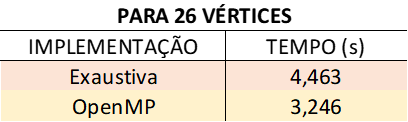

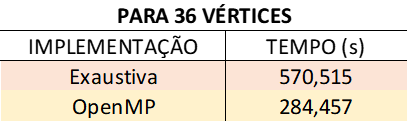

**No Cluster Montado**